In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

## The Data
For this exercise, we've imported the Newsgroups Dataset from SciKit Learn.  The Newsgroups are discussion groups on Usenet, a sort of early Internet forum that was popular in the 80s and 90s.  

The dataset contains 18,000 posts with 20 topics.  

Below, we're paring it down by only keeping posts from the following four categories.  

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

The shape of the data: 

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Here's a sample of some the posts in our set: 

In [5]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

The first post clearly falls under the Computer Graphics topic, since the post mentions textures and different file formats.  Post number 2 seems like it's talking about religious cults, since it mentions Koresh and Jim Jones, so it probably falls under the Talk Religion Misc topic.  Finally the last one seems to be using words associated with space (perijove is the point in the orbit of a satellite of Jupiter nearest the planet's center), so it should fall under the topic, Science Space. 

Let's confirm that these three posts match up with our guesses regarding their topics:

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

The target attribute is the integer index of the category.  I.E., the labels are encoded by corresponding unique integers, and not strings.

In [7]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [8]:
num_topics, num_top_words = 6, 8

## Data Processing

SciKit Learn has a method for extracting word counds and TF-IDF for each document, allowing us to easily create document-term or term-document matrices.  

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
# nltk.download('punkt')

In [10]:
# from nltk import word_tokenize 

# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = stem.WordNetLemmatizer()
#     def __call__(self, doc):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [11]:
vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())

Here we actually apply the fit and transform to create a document term matrix. 

In [12]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [13]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [14]:
vocab = np.array(vectorizer.get_feature_names())

In [15]:
vocab.shape

(26576,)

In [16]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

## Singular Value Decomposition (SVD) 
Singular Value Decomposition is used in topic modeling because it decomposes a data matrix into a multiplication of a matrix with orthogonal columns times a diagonal matrix with relative importance factors time a matrix with orthogonal rows.  

Since we expect words that appear more frequently in one topic to appear less frequently in the other, we could reasonably expect that the topics would independent, or orthogonal to each other.  

Thus, a decomposition technique like SVD is useful to us because it separates out the topics thanks to the inherent orthogonality of its Left and Right Singular matrices.  

The topic modeling technique, Latent Semantic Analysis (LSA), exploits SVD for this purpose: 

Below, we apply SVD to the transformed dataset:

In [17]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 4min 16s, sys: 3.28 s, total: 4min 19s
Wall time: 50.9 s


If this decomposition worked correctly, we should see if the dimensions are compatible.  

In [18]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


We'll probably have to take the transpose of the right most matrix to make it work, but it should result in a matrix with the same dimensions as our original transformed dataset (2034, 26576).

Below, we print out the first four importance factors from the diagonal matrix:

In [19]:
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

__Confirm that U, s, Vh is a decomposition of vectors__

In [20]:
# The shape of the product should match the original transformed data
result = U @ np.diag(s) @ Vh
result.shape

(2034, 26576)

In [21]:
# Alternatively, it can also be computed like this.  
result = (U * s) @ Vh
result.shape

(2034, 26576)

In [22]:
np.testing.assert_array_almost_equal(vectors, result)

__Confirm that U and Vh are orthonormal__

In [23]:
orthoU = U @ U.T
print(orthoU.shape)
np.testing.assert_array_almost_equal(orthoU, np.identity(2034))

(2034, 2034)


In [24]:
orthoV = Vh @ Vh.T
print(orthoV.shape)
np.testing.assert_array_almost_equal(orthoV, np.identity(2034))

(2034, 2034)


__Topics__:  What can we say about the singular values s? 

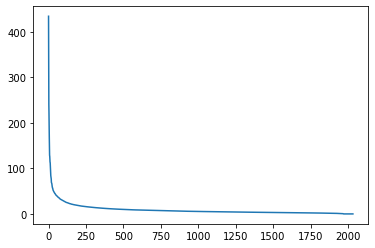

In [25]:
plt.plot(s)

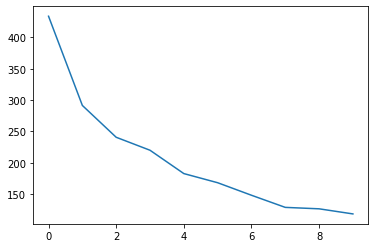

In [26]:
plt.plot(s[:10])

The Singular Values of s are supposed to be a measure of relative importance for each of the decomposed word vectors.  These elbow plots show that as we get closer to 10 singular values, the relative importance drops off rapidly.  This implies that the amount of useful information we can gleam from LSA Topic Modelling can be mostly achieved from the first several singular values alone, and that by association, the corresponding vectors in the Left Singular and Right Singular matrices are the most informative when it comes to topic modelling.

In [27]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [28]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'jpeg graphics space pub edu ray mail send',
 'jesus matthew prophecy messiah psalm isaiah david said',
 'launch commercial satellite market image services satellites launches',
 'data available nasa ftp grass anonymous contact gov',
 'atheists god religious atheism religion believe belief atheist',
 'probe data surface moon mars probes lunar launch']

By returning only the words associated with the top ten singular values in the Left Singular Matrix, we are able to generate 10 groupins of words that, for the most part, contain words consistent with one of the original topics.

## Test Cases for Exercises 

In [29]:
import unittest

class NamesTestCase(unittest.TestCase):
    """ Test for exercises. """
    
    def test_svd_works(self):
        """ Can we reconstruct the data matrix from the components of SVD? """
        correct = vectors
        expected = U @ np.diag(s) @ Vh 
        self.assertEqual(np.testing.assert_array_almost_equal(vectors, result), None)
        
    def test_Uorthonormal(self):
        """ Are U and Vh orthonormal? """
        identitym = np.identity(2034)
        self.assertEqual(np.testing.assert_array_almost_equal(orthoU, identitym), None)
        
    def test_Vhorthonormal(self):
        """ Are U and Vh orthonormal? """
        identitym = np.identity(2034)
        self.assertEqual(np.testing.assert_array_almost_equal(orthoV, identitym), None)
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 1.921s

OK


## Non-negative Matrix Factorization (NMF)
NMF is an alternative to SVD based topic modelling.  The idea is that, instead of using orthogonality of factors to guage the importance of features, we used non-negativity.  NMF factorizes the a non-negative dataset V into non-negative matrics, W and H.  Often, positive factors are more easily interpretable.  

NMF factorizes V into one skinny positive matrix, and one short positive matrix.  W, the skinny positive matrix, is a matrix of features, and H, the shot positive matrix, is a matrix of the importance of the features in each image.  

### NMF from SciKit Learn

In [30]:
m,n=vectors.shape
d=5  # num topics

clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TD-IDF
Topic Frequency-Inverse Document Frequency (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how common/rare the term is.  

TF = (# occurrences of term t in document) / (# of words in document) 
IDF = log(# of documents / # documents with term t in it) 

Then get the TF-IDF score by multiplying the two.  

http://www.tfidf.com/

In [31]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [32]:
newsgroups_train.data[10:20]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [33]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [34]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

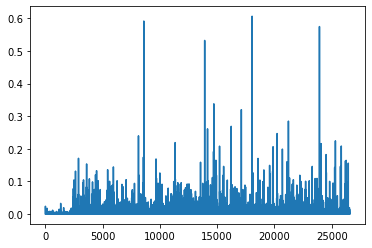

In [35]:
plt.plot(clf.components_[0])

In [36]:
clf.reconstruction_err_

43.71292605795278

#### NMF in Summary

NMF is comparatively fast compared to your stock SVD.  Just be sure to make sure that the matrix is at least tall as it is wide, or else we get an error with fit_transform.  

We can use df_min in CountVectorizer to only look at words that were in at least k of the split texts.

## Efficient Topic Modelling 

__Disadvantages of Classical Algorithms for Decomposition__ 
-  Matrices are huge!  It can take a long time to compute. 
-  Often missing data and/or keeping inaccurate data (sparse matrices? Extraneous info? etc.).  
-  Data Transfer needs to be taken into account as well when running the algorithm.  
-  We may need to leverage GPUs.  

### Truncated SVD
We saved some time using NMF for topic modelling by only focusing on a subset of columns we were interested in.  We can extend this to SVD via Truncated SVD, where we only consider the vectors corresponding to the largest singular values.

### Randomized Algorithms 

We can create randomized matrices that can be component factors in an acceptably rough approximation of the original data matrix.  We start by creating randomized matrices that have vectors formed from normal distributions, and then have the data projected onto them, creating a sort of sample matrix.  The resulting projection is a smaller orthonormal matrix, Q, of our data matrix A such that A is roughly eqaul to QQ^T A. Our final approximation is then B = Q^T A.  Because B is relatively smaller than A, but is still a reasonable close approximation of A, we can compute SVD much faster.

See: http://gregorygundersen.com/blog/2019/01/17/randomized-svd/ or https://research.fb.com/blog/2014/09/fast-randomized-svd/

__Comparing Times between Scikit Learn's Randomized SVD and Facebook's Randomized SVD__

In [37]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 4min 25s, sys: 3.8 s, total: 4min 29s
Wall time: 52.3 s


In [38]:
from sklearn import decomposition
import fbpca

In [39]:
%time u, s, v = decomposition.randomized_svd(vectors, 10)

CPU times: user 15.1 s, sys: 801 ms, total: 15.9 s
Wall time: 4.99 s


Randomized SVD from Facebook's fbpca library:

In [40]:
%time u, s, v = fbpca.pca(vectors, 10)

CPU times: user 3.15 s, sys: 212 ms, total: 3.36 s
Wall time: 743 ms
